In [355]:
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import requests
from bs4 import BeautifulSoup
import time
import json
import sys
from scipy import stats
from sklearn.cross_validation import *

%matplotlib inline

In [356]:
matchup_df = pd.read_csv("temp_matchupdf.csv")

In [357]:
matchup_df.columns

Index([u'AB', u'H', u'PA', u'RL', u'SAC', u'SO', u'TB', u'W', u'bID',
       u'matchID', u'pID', u'AVG', u'OBP', u'ov_AB', u'ov_H', u'ov_PA',
       u'ov_SAC', u'ov_SO', u'ov_TB', u'ov_W', u'ov_AVG', u'ov_OBP',
       u'ov_FACED', u'ov_SO_PCT', u'ov_W_PCT', u'ov_H_PCT', u'ovp_AB',
       u'ovp_H', u'ovp_PA', u'ovp_SAC', u'ovp_SO', u'ovp_TB', u'ovp_W',
       u'ovp_AVG', u'ovp_OBP', u'ovp_FACED', u'ovp_SO_PCT', u'ovp_W_PCT',
       u'ovp_H_PCT'],
      dtype='object')

In [358]:
dftouse=matchup_df.copy()

In [359]:
dftouse.head()

,AB,H,PA,RL,SAC,SO,TB,W,bID,matchID,...,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,5,1,5,R,0,2,1,0,torrc001,torrc001_medlk001,...,13,297,674,97,0.254093,0.302264,188,0.197736,0.064581,0.237683
1,3,0,3,L,1,2,0,0,kinnm002,kinnm002_leita001,...,91,1023,2335,762,0.251296,0.350069,356,0.177112,0.131925,0.218144
2,6,0,6,R,0,0,0,0,telit001,telit001_felds001,...,53,556,1835,383,0.271793,0.341782,347,0.139523,0.096110,0.245671
3,6,2,6,R,0,2,4,0,telit001,telit001_grays001,...,9,189,289,71,0.223203,0.287037,110,0.218750,0.082176,0.204861
4,3,0,4,R,2,3,0,1,schic002,schic002_adamt001,...,34,399,937,270,0.272640,0.356351,243,0.170077,0.115090,0.241262


In [360]:
dftouse.dtypes

AB              int64
H               int64
PA              int64
RL             object
SAC             int64
SO              int64
TB              int64
W               int64
bID            object
matchID        object
pID            object
AVG           float64
OBP           float64
ov_AB           int64
ov_H            int64
ov_PA           int64
ov_SAC          int64
ov_SO           int64
ov_TB           int64
ov_W            int64
ov_AVG        float64
ov_OBP        float64
ov_FACED        int64
ov_SO_PCT     float64
ov_W_PCT      float64
ov_H_PCT      float64
ovp_AB          int64
ovp_H           int64
ovp_PA          int64
ovp_SAC         int64
ovp_SO          int64
ovp_TB          int64
ovp_W           int64
ovp_AVG       float64
ovp_OBP       float64
ovp_FACED       int64
ovp_SO_PCT    float64
ovp_W_PCT     float64
ovp_H_PCT     float64
dtype: object

In [361]:
def compute_supports(df):
    ubids=df.bID.unique()
    pitch = df.groupby('pID').bID.unique()
    bdict={}
    for e,v in zip(pitch.index.values, pitch.values):
        bdict[e] = np.array([item in v for item in ubids])
    pitchers=bdict.keys()
    supports=[]
    for i,p1 in enumerate(pitchers):
        for j,p2 in enumerate(pitchers):
            if  i < j:
                supmask = (bdict[p1] & bdict[p2])
                common_batters = np.sum(supmask)
                supports.append(common_batters)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, bdict

In [362]:
print(dftouse.columns)

Index([u'AB', u'H', u'PA', u'RL', u'SAC', u'SO', u'TB', u'W', u'bID',
       u'matchID', u'pID', u'AVG', u'OBP', u'ov_AB', u'ov_H', u'ov_PA',
       u'ov_SAC', u'ov_SO', u'ov_TB', u'ov_W', u'ov_AVG', u'ov_OBP',
       u'ov_FACED', u'ov_SO_PCT', u'ov_W_PCT', u'ov_H_PCT', u'ovp_AB',
       u'ovp_H', u'ovp_PA', u'ovp_SAC', u'ovp_SO', u'ovp_TB', u'ovp_W',
       u'ovp_AVG', u'ovp_OBP', u'ovp_FACED', u'ovp_SO_PCT', u'ovp_W_PCT',
       u'ovp_H_PCT'],
      dtype='object')


In [363]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all conglomerations recomputed
    this is used when a frame is subsetted.
    """
    ldfb=ldf.groupby('bID')
    ldfp=ldf.groupby('pID')
    nldf=ldf.copy()
    
    #Conglomerate pitcher stats
    nldf.set_index(['pID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ovp_'+col] = ldfp[col].sum()
    nldf['ovp_AVG'] = nldf['ovp_H']/nldf['ovp_AB']
    nldf['ovp_FACED']= ldfp.AB.count()
    nldf['ovp_OBP'] = (nldf['ovp_H'] + nldf['ovp_W'])/nldf['ovp_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ovp_' + col + '_PCT'] = nldf['ovp_' + col] / nldf['ovp_PA']
    nldf.reset_index(inplace=True)
    
    #Conglomerate batter stats
    nldf.set_index(['bID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ov_'+col] = ldfb[col].sum()
    nldf['ov_AVG'] = nldf['ov_H']/nldf['ov_AB']
    nldf['ov_FACED']= ldfb.AB.count()
    nldf['ov_OBP'] = (nldf['ov_H'] + nldf['ov_W'])/nldf['ov_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ov_' + col + '_PCT'] = nldf['ov_' + col] / nldf['ov_PA']
    nldf.reset_index(inplace=True)
    return nldf

In [364]:
def make_smaller(df, pacountp, pacountb):
    smallidf1=df[(df.ovp_PA > pacountp) & (df.ov_PA > pacountb)]
    smalldf=recompute_frame(smallidf1)
    return smalldf

In [365]:
def make_smaller_gen(df, col, limit, greater=True):
    if greater:
        smallidf = df[(df[col] > limit)]
    else:
        smallidf = df[(df[col] < limit)]
    return recompute_frame(smallidf)

##Shrink dataset: Minimum plate-appearances per matchup, and PA per batter/pitcher

In [366]:
#Set minimum number of times batter/pitcher faced each other
smalldf = make_smaller_gen(dftouse, 'PA', 7)

#Set minimum number of total plate appearances for batter and pitcher
smalldf = make_smaller(smalldf, 100, 100)

smalldf.to_csv('small.csv', index=False)

In [367]:
print "Number of Matchups",smalldf.shape[0]
print "Number of Batters", smalldf.bID.unique().shape[0]
print "Number of Pitchers", smalldf.pID.unique().shape[0]
s,d=compute_supports(smalldf)

Number of Matchups 109688
Number of Batters 910
Number of Pitchers 1297
mean support 13.6844248836 median support 5.0


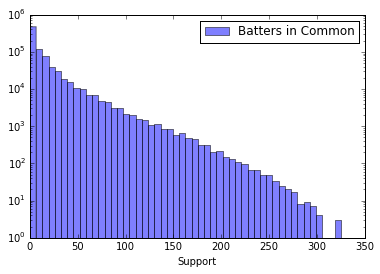

In [368]:
plt.hist(s, bins=50, alpha=0.5, label="Batters in Common", log=True);
plt.xlabel('Support')
plt.legend();
plt.show()

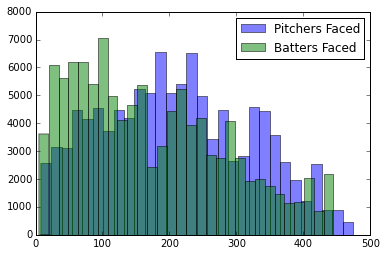

In [369]:
plt.hist(smalldf.ov_FACED, bins=30, alpha=0.5, label='Pitchers Faced')
plt.hist(smalldf.ovp_FACED, bins=30, alpha=0.5, label='Batters Faced')
plt.legend();
plt.show()

In [370]:
print smalldf.shape
smalldf=smalldf.drop_duplicates(['bID','pID'])
print smalldf.shape
#smalldf.dtypes
smalldf.head(5)

(109688, 39)
(109688, 39)


,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,...,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,schic002,benea001,9,0,9,R,1,4,0,0,...,46,609,1713,379,0.271504,0.352117,136,0.177810,0.110657,0.241460
1,schic002,browk001,11,1,11,R,0,6,1,0,...,47,892,1974,407,0.252946,0.313891,222,0.178793,0.081579,0.232311
2,schic002,fassj001,11,2,11,L,1,5,4,0,...,40,582,1587,351,0.281770,0.356866,185,0.173369,0.104558,0.252309
3,schic002,glavt001,14,3,14,L,1,3,5,0,...,102,985,3852,852,0.279725,0.352668,280,0.117081,0.101272,0.251397
4,schic002,hampm001,16,2,16,L,1,6,2,0,...,53,666,2355,557,0.284609,0.359243,232,0.124742,0.104327,0.254917


#Splitting into Test and Training Sets

In [371]:
print smalldf.shape,
smalldf[smalldf.ov_FACED > 100].shape

(109688, 39)

(88234, 39)

In [372]:
trainlist=[]
testlist=[]
validatelist=[]
take=21 #21 matchups between validation and test set
for k, v in smalldf.groupby('bID'):
    if len(v) > 100: #batter has faced at least 150 pitchers
        train_rows, test_valid_rows = train_test_split(v, test_size=take)
        trainlist.append(train_rows)
        valid_rows, test_rows = train_test_split(test_valid_rows, test_size=0.4)
        validatelist.append(valid_rows) 
        testlist.append(test_rows) 
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(101036, 39) (4944, 39) (3708, 39)


In [373]:
#Make sure each pitcher ID was encountered in training set
maskval= np.in1d(validatedf.pID, traindf.pID) 
masktest = np.in1d(testdf.pID, traindf.pID)
print np.sum(~maskval), np.sum(~masktest)

0 0


In [374]:
traindf=recompute_frame(traindf)
validatedf=recompute_frame(validatedf)
testdf=recompute_frame(testdf)
validatedf=validatedf[['bID', 'pID','AVG']]
testdf=testdf[['bID', 'pID', 'AVG']]
traindf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,...,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,aberb001,bellr003,9,1,10,R,0,0,1,1,...,20,200,897,158,0.298721,0.373235,115,0.134499,0.106254,0.266980
1,aberb001,buehm001,13,2,14,L,0,3,6,1,...,125,1330,4775,649,0.276859,0.324847,415,0.135992,0.066360,0.258487
2,aberb001,burkj001,8,2,9,R,0,1,2,1,...,52,642,2176,359,0.291645,0.351326,207,0.150669,0.084253,0.267073
3,aberb001,castf001,7,1,11,R,0,0,1,4,...,26,337,1173,219,0.285088,0.354029,140,0.148393,0.096433,0.257596
4,aberb001,clemr001,25,7,26,R,1,2,9,1,...,60,1457,2717,674,0.240665,0.316452,265,0.215756,0.099807,0.216644


#The baseline model

In [375]:
ybar = traindf.H.sum() / float(traindf.AB.sum())
ybar

0.274200240396544

In [376]:
ubids=traindf.bID.unique()#unique-user-ids
upids=traindf.pID.unique()#unique-item-ids
print ubids,upids,len(upids),len(ubids)

['aberb001' 'abreb001' 'abrej003' 'ackld001' 'adamm002' 'adamr002'
 'alexm001' 'alfoe001' 'allec001' 'alomr001' 'aloms001' 'alony001'
 'aloum001' 'altuj001' 'alvap001' 'amara001' 'ameza001' 'andeb003'
 'andeg001' 'andem003' 'andir001' 'andre001' 'ankir001' 'aokin001'
 'arcio001' 'arenj001' 'arenn001' 'ariaj001' 'aschc001' 'ashba002'
 'atkig001' 'aurir001' 'ausmb001' 'avila001' 'avilm001' 'aybae001'
 'aybaw001' 'baerc001' 'bagwj001' 'bakej001' 'bakej002' 'bakop001'
 'baldr001' 'barar001' 'bardj001' 'barfj003' 'barmc001' 'barnb002'
 'barnd001' 'barrm003' 'bartd001' 'bartj001' 'batit001' 'bautd001'
 'bautj002' 'bay-j001' 'beckg001' 'belld002' 'bellm002' 'bellr002'
 'belta001' 'beltb001' 'beltc001' 'benng001' 'bergd002' 'bergp001'
 'berkl001' 'bernr001' 'berra001' 'betay001' 'betew001' 'bigbl001'
 'biggc001' 'blacc001' 'blakc001' 'blalh001' 'blang001' 'blanh001'
 'blank002' 'bloow001' 'blumg001' 'boesb001' 'bogax001' 'bogub001'
 'bondb001' 'bonie001' 'boona001' 'boonb002' 'borbj001' 'borcj

In [377]:
ubidmap={v:k for k,v in enumerate(ubids)}#of length U
upidmap={v:k for k,v in enumerate(upids)}#of length M

In [378]:
batter_biases={}
pitcher_biases={}

for uindx, batter in enumerate(ubids):
    batter_row=traindf[traindf.bID==batter]
    yb=batter_row.ov_AVG.unique()[0]
    bbaseline = yb - ybar
    batter_biases[batter]=bbaseline

for iindx, pit in enumerate(upids):
    pit_row=traindf[traindf.pID==pit]
    yp=pit_row.ovp_AVG.unique()[0]
    pbaseline = yp - ybar
    pitcher_biases[pit]=pbaseline

In [379]:
pitcher_biases

{'corbp001': -0.017605516175920488,
 'litsj001': -0.0055239625459542196,
 'ledew001': 0.021690170562360112,
 'torrc001': 0.031355315159011576,
 'davim001': -0.02186379179841319,
 'kinnm002': 0.032353670808529966,
 'gonzj003': -0.015216349442392807,
 'furbc001': -0.045344519003509165,
 'eldrc001': 0.015401992680915855,
 'florr001': 0.0035775373812337863,
 'almaa001': -0.063262740396544004,
 'figun001': 0.011514045317741695,
 'ramoa001': 0.0070497596034559962,
 'petrd001': 0.024307222290023134,
 'bohab001': 0.025397614831338011,
 'basta001': -0.069282207609658752,
 'ryu-h001': 0.011514045317741695,
 'mussm001': -0.012200515461872008,
 'arrob001': 0.0051907500288209119,
 'schic002': -0.015017540444246358,
 'coggd001': 0.00060891990879952118,
 'olsog003': 0.011514045317741695,
 'turnd001': -0.020468897112961904,
 'kellj001': 0.011165613261992557,
 'castc002': 0.019133092936789331,
 'ondrl001': -0.0085752403965440038,
 'cainm001': -0.03020557847483582,
 'wrigj001': 0.022513374626930149,
 'w

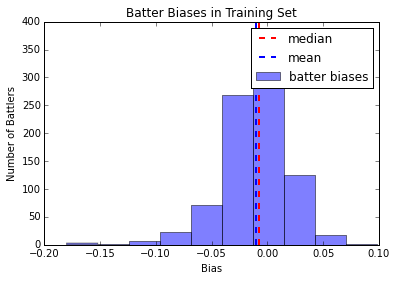

In [380]:
plt.hist(batter_biases.values(), alpha=0.5, label="batter biases");
plt.xlabel('Bias')
plt.ylabel('Number of Battlers')
plt.title('Batter Biases in Training Set')
plt.axvline(np.median(batter_biases.values()), color='r', linestyle='dashed',label="median", linewidth=2)
plt.axvline(np.mean(batter_biases.values()), color='b', linestyle='dashed',label="mean", linewidth=2)
plt.legend();

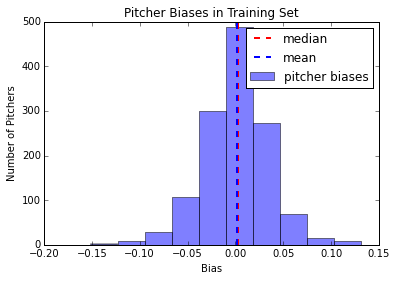

In [381]:
plt.hist(pitcher_biases.values(), alpha=0.5, label="pitcher biases");
plt.xlabel('Bias')
plt.ylabel('Number of Pitchers')
plt.title('Pitcher Biases in Training Set')
plt.axvline(x=np.median(pitcher_biases.values()), color='r', linestyle='dashed',label="median", linewidth=2)
plt.axvline(x=np.mean(pitcher_biases.values()), color='b', linestyle='dashed',label="mean", linewidth=2)
plt.legend();

In [382]:
train_avgs={'mean':ybar, 'batters':batter_biases, 'pitchers':pitcher_biases}

In [383]:
train_avgs['batters']

{'aberb001': -0.056930045410471586,
 'abreb001': 0.013243027379552796,
 'abrej003': 0.098527032330728737,
 'ackld001': -0.025316311825115428,
 'adamm002': 0.057638324625877535,
 'adamr002': -0.030754547512648861,
 'alexm001': -0.050866907063210676,
 'alfoe001': 0.0096598047501828543,
 'allec001': 0.0096980646882017796,
 'alomr001': 0.023639025886683096,
 'aloms001': 0.006585785804329336,
 'alony001': 0.00022803403173043968,
 'aloum001': 0.025716217414650633,
 'altuj001': 0.027724784932736668,
 'alvap001': -0.031262387289199361,
 'amara001': -0.031775997972301573,
 'ameza001': -0.0069191344057605852,
 'andeb003': -0.050516029870228213,
 'andeg001': 0.016271071078865829,
 'andem003': -0.010417965448881739,
 'andir001': -0.01711522015362904,
 'andre001': -0.012215847977368965,
 'ankir001': -0.019323777457662339,
 'aokin001': 0.01863465056918806,
 'arcio001': -0.033459499655803276,
 'arenj001': -0.091079221288263762,
 'arenn001': 0.0093818491556947881,
 'ariaj001': 0.007489900448526432,
 '

In [384]:
predictions={'universal':ybar+np.zeros(len(testdf))}
predictions_valid={'universal':ybar+np.zeros(len(validatedf))}

In [385]:
#your code here
####

#initializing list
list_pred=[]

#for each row in test df:
for row in range(len(testdf)):
    batterid_test=testdf.iloc[row]['bID'] #get the batter
    pitcherid_test=testdf.iloc[row]['pID'] #get the restuarant id
    list_pred.append(ybar+batter_biases[batterid_test]+pitcher_biases[pitcherid_test]) #call biases and calc. pred.
    predictions["baseline"]=list_pred #add to dictionary
print len(predictions['baseline'])

#initializing list
list_pred2=[]
#for each row in validate df:
for row in range(len(validatedf)):
    batterid_val=validatedf.iloc[row]['bID'] #get the batter
    pitcherid_val=validatedf.iloc[row]['pID'] #get the restuarant id
    list_pred2.append(ybar+batter_biases[batterid_val]+pitcher_biases[pitcherid_val])#call biases and calc. pred.
    predictions_valid["baseline"]=list_pred2 #add to dictionary
print len(predictions_valid['baseline'])

3708
4944


In [386]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.sum(diff**2)/len(diff))

In [387]:
predictions['universal']

array([ 0.27420024,  0.27420024,  0.27420024, ...,  0.27420024,
        0.27420024,  0.27420024])

In [388]:
def compare_results(avg_actual, avg_predicted, ylow=0, yhigh=1, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=np.round(avg_actual, decimals=2), predicted=avg_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 'o-', label="means for %s" % model)
    c=cl.get_color()
    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1,label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,1],[0,1], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        #ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left",prop={'size':23})
    rmse=get_rmse(avg_actual, avg_predicted)
    print "RMSE for %s" % model, rmse
    rmse=3
    return ax,rmse

RMSE for baseline 0.134443680599


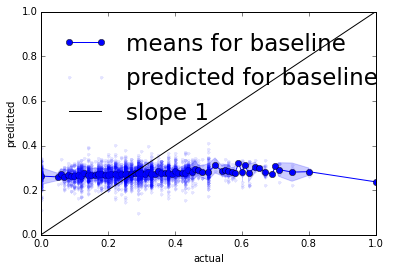

In [389]:
compare_results(testdf.AVG,predictions['baseline'], model="baseline", predicteds=True);

#KNN Model 

In [151]:
#Ali's function 
def sim_batters(bID, pID, df):
    batter_row = df.loc[df['bID'] == bID]
    AVG = batter_row['AVG']
    OBP = batter_row['OBP']
    if (batter_row['RL'] == 'R'):
        hand = 0
    else:
        hand = 1
    SAC = batter_row['SAC']
    # continue for other statistics
    
    # find list of bIDs who have faced given pID
    p_batters = df.loc[df['pID'] == pID]
    
    similarity = {}
    # for each batter, calculate similarity
    for b in p_batters:
        comp_b_row = df.loc[df['bID'] == b]
        comp_AVG = batter_row['AVG']
        comp_OBP = batter_row['OBP']
        if (batter_row['RL'] == 'R'):
            comp_hand = 0
        else:
            comp_hand = 1
        comp_SAC = batter_row['SAC']
        # continue for other statistics
        
        #calculate similarity
        AVG_score = AVG_weight*(AVG - comp_AVG)/AVG
        OBP_score = OBP_weight*(OBP - comp_OPB)/OBP
        if (hand == comp_hand):
            hand_score = hand_weight
        else:
             hand_score = 0   
        SAC_score = SAC_weight*(SAC - comp_SAC)/SAC
        total_score = AVG_score + OBP_score + hand_score + SAC_score
        similarity[b] = total_score
    # return top x bIDs with lowest scores
    sorted_sim = sorted(similarity.items(), key=operator.itemgetter(1))
    sim_batters = sorted_sim.keys
    return sim_batters[:10]
    

In [390]:
#for each restaurant get the unique userids who rated it
batters_for_pitchers = traindf.groupby('pID').bID.unique()
pitchers=upids
lpitch=len(pitchers)
supports=[[[] for i in range(lpitch)] for i in range(lpitch)]
supporthistlist=[]
for i,p1 in enumerate(pitchers):
    for j,p2 in enumerate(pitchers):
        if  i <= j:#its symmetric
            if p1==p2:
                common_reviewers=users_for_restaurants[p1]
            else:
                common_reviewers = set(batters_for_pitchers[p1]).intersection(set(batters_for_pitchers[p2]))
                supporthistlist.append(len(common_reviewers))
            supports[i][j]=common_reviewers
            supports[j][i]=common_reviewers
print "Mean and Median support is:",np.mean(supporthistlist), np.median(supporthistlist)

Mean and Median support is: 11.593010223 4.0


In [391]:
from scipy.stats.stats import pearsonr
# calculate pearson sim between 2 pitchers
def pearson_sim(pitcher1, pitcher2, n_common):
    try:
        p1_avg = pitcher1['ov_AVG']
        p2_avg = pitcher2['ov_AVG']
        p1_actual = pitcher1['AVG']
        p2_actual = pitcher2['AVG']
        norm1 = []
        norm2 = []
        if (n_common == 0) or (n_common==1):
            return 0;
        for i in range(0,len(p1_avg)):
            norm1.append(p1_avg[i] - p1_actual[i])
            norm2.append(p2_avg[i] - p2_actual[i])
        rho = sp.stats.pearsonr(norm1,norm2)[0]
        if np.isnan(rho):
            return 0;
        return rho
    except:
        p1_avg = pitcher1['ov_AVG'].values
        p2_avg = pitcher2['ov_AVG'].values
        p1_actual = pitcher1['AVG'].values
        p2_actual = pitcher2['AVG'].values
        norm1 = []
        norm2 = []
        if (n_common == 0) or (n_common==1):
            return 0;
        for i in range(0,len(p1_avg)):
            norm1.append(p1_avg[i] - p1_actual[i])
            norm2.append(p2_avg[i] - p2_actual[i])
        rho = sp.stats.pearsonr(norm1,norm2)[0]
        if np.isnan(rho):
            return 0;
        return rho

In [392]:
def get_pitcher_avgs(pID, df, set_of_batters):
    """
    given a pitcher id and a set of batters, return the sub-dataframe of their
    averages.
    """
    mask = (df.bID.isin(set_of_batters)) & (df.pID==pID)
    avgs = df[mask]
    avgs = avgs[avgs.bID.duplicated()==False]
    return avgs

In [393]:
class Database:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, pindexmap, supports):
        "the constructor, takes a map of restaurant id's to integers"
        database={}
        self.pindexmap=pindexmap
        self.supports=supports
        l_keys=len(self.pindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)

    def set_supports(self, supports):
        self.supports=supports
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.pindexmap[b1]][self.pindexmap[b2]]
        nsup=self.database_sup[self.pindexmap[b1]][self.pindexmap[b2]]
        return (sim, nsup)

In [394]:
db=Database(upidmap, supports)

In [395]:
def mapper1(row):
    return row[1], (row[2], row[12], row[34])

In [396]:
def combiner(items):
    indict={}
    for key, value in items:
        if not indict.has_key(key):
            indict[key]=[]
        indict[key].append(value)
    return indict.items()

In [397]:
def reducer1(the_input):
    bID, values = the_input
    avgs=[]
    for pID,AVG,ov_AVG in values:
        avgs.append((pID,(AVG, ov_AVG)))
    return bID, avgs

In [398]:
from itertools import combinations_with_replacement
def mapper2(list_input):
    nlist = []
    comb = list(combinations_with_replacement(list_input[1], 2))
    for item in comb:
        if item[0][0] > item[1][0]:
            biz_pair = item[1][0], item[0][0]
            star_pair = item[1][1], item[0][1]
        else:
            biz_pair = item[0][0], item[1][0]
            star_pair = item[0][1], item[1][1]
        tup = (biz_pair, star_pair)
        nlist.append(tup)
    return nlist

In [399]:
def combiner_list(itemslist):
    indict={}
    for items in itemslist:
        for key, value in items:
            if not indict.has_key(key):
                indict[key]=[]
            indict[key].append(value)
    return indict.items()

In [400]:
def reducer2(item_dict):
    p1_id = item_dict[0][0]
    p2_id = item_dict[0][1]
    AVG_1 = [x[0][0] for x in item_dict[1]]
    AVG_2 = [x[1][0] for x in item_dict[1]]
    ov_AVG_1 = [x[0][1] for x in item_dict[1]]
    ov_AVG_2 = [x[1][1] for x in item_dict[1]]
    n_common = len(item_dict[1])
    p1_dict = {'ov_AVG': ov_AVG_1, 'AVG': AVG_1}
    p2_dict = {'ov_AVG': ov_AVG_2, 'AVG': AVG_2}
    rho = pearson_sim(p1_dict, p2_dict, n_common)
    return (p1_id, p2_id),(rho, n_common)

In [401]:
def map_reduce(tuples):
    mapped1=map(mapper1, tuples)
    combine1=combiner(mapped1)
    reduced1=reduce(lambda x,y: x + [reducer1(y)], combine1, [])
    mapped2=map(mapper2,reduced1)
    combine2=combiner_list(mapped2)
    output=reduce(lambda x,y: x + [reducer2(y)], combine2, [])
    return output

In [402]:
%%time
tuples=traindf.itertuples()
sims=map_reduce(tuples)

CPU times: user 1h 26min 33s, sys: 2min 49s, total: 1h 29min 22s
Wall time: 1h 29min 59s


In [403]:
import cPickle as pickle
pickle.dump(sims,open('sims2.p','wb'))
# sims = pickle.load(open('sims2.p','rb'))

In [404]:
def populate_from_mr(db, df, mapredlist):
    for tpair,vpair in mapredlist:
        i1=db.pindexmap[tpair[0]]
        i2=db.pindexmap[tpair[1]]
        db.database_sim[i1][i2]=vpair[0]
        db.database_sup[i1][i2]=vpair[1]
        db.database_sim[i2][i1]=vpair[0]
        db.database_sup[i2][i1]=vpair[1]

In [405]:
populate_from_mr(db, traindf, sims)

In [406]:
db2=Database(upidmap, supports)

In [407]:
def calculate_similarity(db, df, p1, p2, similarity_func):
    # find common batters
    common_batters = db.supports[db.pindexmap[p1]][db.pindexmap[p2]]
    n_common=len(common_batters)
    if p1==p2:
        return 1., n_common
    #get averages
    p1_ov_AVG = get_pitcher_avgs(p1, df, common_batters)
    p2_ov_AVG = get_pitcher_avgs(p2, df, common_batters)
    sim=similarity_func(p1_ov_AVG, p2_ov_AVG, n_common)
    return sim, n_common

def populate_by_calculating(db, df, similarity_func):
    items=db.pindexmap.items()
    for b1, i1 in items:
        for b2, i2 in items:
            if i1 <= i2:
                sim, nsup=calculate_similarity(db, df, b1, b2, similarity_func)
                db.database_sim[i1][i2]=sim
                db.database_sim[i2][i1]=sim
                db.database_sup[i1][i2]=nsup
                db.database_sup[i2][i1]=nsup

In [408]:
%%time
populate_by_calculating(db2, traindf, pearson_sim)

KeyboardInterrupt: 

In [409]:
import cPickle as pickle
pickle.dump(db2,open('db2.p','wb'))
# db2 = pickle.load(open('db2.p','rb'))

In [410]:
smalldf.sort('ovp_FACED').pID.unique()

array(['dotsr001', 'bannf001', 'forsb001', ..., 'hernl003', 'hudst001',
       'buehm001'], dtype=object)

In [411]:
tpair=('buehm001', 'hudst001') # Mark Buehrle vs. Tim Hudson
print db.get(tpair[0],tpair[1])

(-0.0093069421585641084, 205)


In [412]:
print db.get(tpair[1],tpair[0]),db2.get(tpair[1],tpair[0])
print db.get(tpair[0],tpair[0]),db2.get(tpair[0],tpair[0])

(-0.0093069421585641084, 205) (0.0, 0)
(1.0, 415) (0.0, 0)


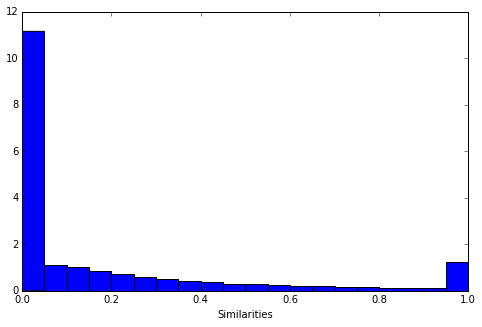

In [413]:
fig, axis = plt.subplots(figsize=(8,5))
sims = db.database_sim.flatten()
axis.hist(sims[sims>=0], bins=20, normed=True)
axis.set_xlabel('Similarities')

In [414]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

In [415]:
from operator import itemgetter
def knearest(p_id, set_of_pitchers, dbase, k=7, reg=3.):
    similars=[]
    for other_p_id in set_of_pitchers:
        if other_p_id!=p_id:
            sim, nc=dbase.get(p_id, other_p_id)
            ssim=shrunk_sim(sim, nc, reg=reg)
            simdist=(1. - ssim)/2.
            similars.append((other_p_id, simdist, nc ))
    similars=sorted(similars, key=itemgetter(1))
    return similars[0:k]

In [416]:
def get_batters_pitchers(df, b_id):
    dfbatter=df[df.bID==b_id]
    dfbatterdedup=dfbatter.drop_duplicates('pID')
    return dict(zip(dfbatterdedup.pID.values, dfbatterdedup.AVG.values))

In [423]:
def get_avg(set_of_pitchers, train_map, dbase, p_id, batter_id, k=7, reg=3.):
    mu=train_map['mean']
    batter_bias = train_map['batters'][batter_id]
    nsum=0.
    scoresum=0.
    nears=knearest(p_id, set_of_pitchers, dbase, k=k, reg=reg)
    pitcher_bias=train_map['pitchers'][p_id]
    scores=[]
    for p,s,nc in nears:
        ssim = 1-s
        scoresum=scoresum+ssim
        scores.append(ssim)
        p_biases = train_map['pitchers'][p]
        p_avgs = set_of_pitchers[p]
        dif=(p_avgs - (p_biases + batter_bias + mu))
        nsum=nsum+ssim*dif
    baseline=(batter_bias +pitcher_bias + mu)
    if scoresum > 0.:
        val =  nsum/scoresum + baseline
    else:
        val=baseline
    return val

In [418]:
trainbatter=traindf.loc[100].bID
try:
    testpitcher=testdf[testdf.bID==trainbatter].pID.values[0]
except:
    testpitcher=testdf[testdf.bID==trainbatter].pID
print trainbatter, testpitcher

abreb001 swara001


In [419]:
testdf[testdf.bID=='abreb001'].pID.values

array(['swara001', 'downs001', 'sherg001', 'browj003', 'papej001',
       'weavj002', 'gonzj003', 'hammj002', 'batim001'], dtype=object)

In [420]:
traindf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,...,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,aberb001,bellr003,9,1,10,R,0,0,1,1,...,20,200,897,158,0.298721,0.373235,115,0.134499,0.106254,0.266980
1,aberb001,buehm001,13,2,14,L,0,3,6,1,...,125,1330,4775,649,0.276859,0.324847,415,0.135992,0.066360,0.258487
2,aberb001,burkj001,8,2,9,R,0,1,2,1,...,52,642,2176,359,0.291645,0.351326,207,0.150669,0.084253,0.267073
3,aberb001,castf001,7,1,11,R,0,0,1,4,...,26,337,1173,219,0.285088,0.354029,140,0.148393,0.096433,0.257596
4,aberb001,clemr001,25,7,26,R,1,2,9,1,...,60,1457,2717,674,0.240665,0.316452,265,0.215756,0.099807,0.216644


In [424]:
def get_actual(df, b_id, p_id):
    return df[(df.bID==b_id) & (df.pID==p_id)]['AVG'].values[0]

print "Actual", get_actual(testdf, trainbatter, testpitcher)
print "Predicted",get_avg(get_batters_pitchers(traindf, trainbatter), train_avgs, db, testpitcher, trainbatter, k=2, reg=3.)

Actual 0.222222222222
Predicted 0.175812884668


In [425]:
def get_avgs_batter_nbd(indf, traindf, train_map, db, k=2, reg=3.):
    zips=zip(indf.pID, indf.bID, indf.AVG)
    preds=[]
    actuals=[]
    for (r,u,actual) in zips:
        pred=get_avg(get_batters_pitchers(traindf, u),train_map, db, r,u, k, reg)
        preds.append(pred)
        actuals.append(actual)
    return np.array(preds), np.array(actuals)

In [ ]:
%%time
pt, at = get_avgs_batter_nbd(traindf, traindf, train_avgs, db, k=6, reg=4.)
compare_results(at,pt, model="knn(user) on training k=6, reg=4", predicteds=True)

In [303]:
%%time
k = range(80,85,1)
reg = range(1,5,1)
rmsedict = {}
for kval in k:
    for regval in reg:
        pt, at = get_avgs_batter_nbd(validatedf, traindf, train_avgs, db, k=kval, reg=regval)
        rmse = get_rmse(at, pt)
        key = (kval, regval)
        rmsedict[key] = rmse

CPU times: user 15min 29s, sys: 8.49 s, total: 15min 38s
Wall time: 16min 11s


In [304]:
mintup=min(rmsedict, key=rmsedict.get)
mintup

(82, 2)

In [305]:
bestk, bestreg = mintup
predictions["knn"], atknn = get_avgs_batter_nbd(testdf, traindf,train_avgs, db, k=bestk, reg=bestreg)
predictions_valid["knn"], atvalid = get_avgs_batter_nbd(traindf, traindf, train_avgs, db, k=bestk, reg=bestreg)

RMSE for knn(user) on test k=82, reg=2 0.134974643191


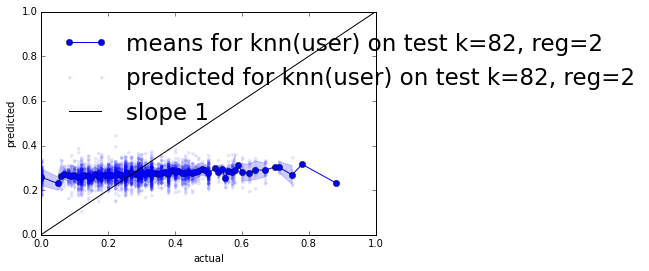

In [306]:
ax, rmse_knn = compare_results(testdf.AVG, predictions['knn'], model=("knn(user) on test k=" + str(bestk) + ", reg=" + str(bestreg)), predicteds=True)
# compare_results(testdf.stars,predictions['baseline'], model="baseline", predicteds=True, onsame=ax)

In [309]:
%%time
k2 = range(1,30,5)
reg2 = range(1,10,2)
rmsedict2 = {}
for kval in k2:
    for regval in reg:
        pt, at = get_avgs_batter_nbd(testdf, traindf, train_avgs, db, k=kval, reg=regval)
        rmse = get_rmse(at, pt)
        key = (kval, regval)
        rmsedict2[key] = rmse

CPU times: user 13min 16s, sys: 4.86 s, total: 13min 21s
Wall time: 13min 27s


In [310]:
mintup2=min(rmsedict2, key=rmsedict2.get)
mintup2

(26, 4)

RMSE for knn(user) on test k=26, reg=4 0.0989930806957
CPU times: user 14min 42s, sys: 3.84 s, total: 14min 46s
Wall time: 14min 50s


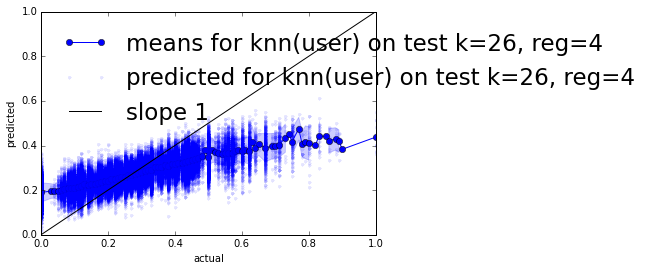

In [311]:
%%time
bestk2, bestreg2 = mintup2
pt, at = get_avgs_batter_nbd(traindf, traindf, train_avgs, db, k=bestk2, reg=bestreg2)
compare_results(at,pt, model=("knn(user) on test k=" + str(bestk2) + ", reg=" + str(bestreg2)), predicteds=True)

RMSE for knn(user) on training k=82, reg=2 0.113609491707
CPU times: user 16min 38s, sys: 9.6 s, total: 16min 47s
Wall time: 17min 10s


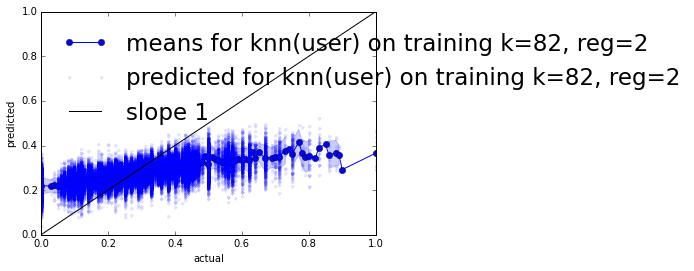

In [308]:
%%time
pt, at = get_avgs_batter_nbd(traindf, traindf, train_avgs, db, k=82, reg=2.)
compare_results(at,pt, model="knn(user) on training k=82, reg=2", predicteds=True)